# Прогноз оттока клиентов из сети фитнесс-центров.

#### <a href="#contents">Шаг 1: Загрузка библиотек, выгрузка данных, проверка на наличие дупликатов, пропусков и соответствие типам данных

In [1]:
# импортируем необходмые библиотеки
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from math import ceil
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

!pip3 install termcolor
from termcolor import colored
warnings.filterwarnings('ignore')
#pd.set_option('max_columns', None)
pd.set_option('display.max_columns', 500)
pd.options.display.float_format= '{:.3f}'.format
%config InlineBackend.figure_format = 'svg'

In [2]:
# загрузим датасет 
#gym = pd.read_csv('/datasets/gym_churn.csv', sep=',')
gym = pd.read_csv('gym_churn.csv', sep=',')

In [3]:
display(gym.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

Пропусков в датасете нет, все типы данных корректные, переведем все названия столбцов к нижнему регистру для удобства.

In [4]:
display(gym.head())

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                        14.227                  5.000   
1             1   31                       113.203                 12.000   
2             0   28                       129.448                  1.000   
3             1   33                        62.670                 12.000   
4             0   26                       198.362                  1.000   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0         3                      0.020                              0.000   
1         7                      1.923                              1.910   
2         2                      1.859                              1.737   
3         2                      3.206                              3.357   
4         3                      1.114                              1.120   

   Churn  
0      0  
1      0  
2      0  
3      0  
4      0

- Churn — факт оттока в текущем месяце
- gender — пол
- Near_Location — проживание или работа в районе, где находится фитнес-центр
- Partner — сотрудник компании-партнёра клуба
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга»(использовал промо-код от знакомого при оплате первого абонемента)
- Phone — наличие контактного телефона
- Age — возраст
- Lifetime — время с момента первого обращения в фитнес-центр (в месяцах)
- Contract_period — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах)
- Group_visits — факт посещения групповых занятий
- Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента
- Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц
- Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

In [5]:
# заменим верхний регистр на нижний 
gym.columns = gym.columns.str.lower()
list(gym)

['gender',
 'near_location',
 'partner',
 'promo_friends',
 'phone',
 'contract_period',
 'group_visits',
 'age',
 'avg_additional_charges_total',
 'month_to_end_contract',
 'lifetime',
 'avg_class_frequency_total',
 'avg_class_frequency_current_month',
 'churn']

#### <a href="#contents">Шаг 2: Исследовательский анализ данных (EDA)

In [6]:
display(gym.describe().T)

count    mean    std    min    25%  \
gender                            4000.000   0.510  0.500  0.000  0.000   
near_location                     4000.000   0.845  0.362  0.000  1.000   
partner                           4000.000   0.487  0.500  0.000  0.000   
promo_friends                     4000.000   0.308  0.462  0.000  0.000   
phone                             4000.000   0.903  0.295  0.000  1.000   
contract_period                   4000.000   4.681  4.550  1.000  1.000   
group_visits                      4000.000   0.412  0.492  0.000  0.000   
age                               4000.000  29.184  3.258 18.000 27.000   
avg_additional_charges_total      4000.000 146.944 96.356  0.148 68.869   
month_to_end_contract             4000.000   4.323  4.191  1.000  1.000   
lifetime                          4000.000   3.725  3.749  0.000  1.000   
avg_class_frequency_total         4000.000   1.879  0.972  0.000  1.181   
avg_class_frequency_current_month 4000.000   1.767  1.053  0.000  0.963   
churn                             4000.000   0.265  0.442  0.000  0.000   

                                      50%     75%     max  
gender                              1.000   1.000   1.000  
near_location                       1.000   1.000   1.000  
partner                             0.000   1.000   1.000  
promo_friends                       0.000   1.000   1.000  
phone                               1.000   1.000   1.000  
contract_period                     1.000   6.000  12.000  
group_visits                        0.000   1.000   1.000  
age                                29.000  31.000  41.000  
avg_additional_charges_total      136.220 210.950 552.591  
month_to_end_contract               1.000   6.000  12.000  
lifetime                            3.000   5.000  31.000  
avg_class_frequency_total           1.833   2.536   6.024  
avg_class_frequency_current_month   1.720   2.510   6.147  
churn                               0.000   1.000   1.000

- Пол представлен примерно поровну.
- Большинство клиентов (85%) проживают или работают около фитнес-центра.
- Почти половина клиентов являются сотрудниками компаний-партнёров клуба, т.е. оформили абонемент со скидкой.
- 31% клиентов попали в зал по акции "приведи друга".
- Телефон указан в 90% анкет. Больше половины клиентов имеют действующий контракт на 1 месяц.
- 41% клиентов посещают групповые занятия.
- Средний возраст клиента - 29 лет.
- Средняя суммарная выручка от доп. услуг фитнес-центра - 147 ед.
- Средний срок окончания действия текущего абонемента - 4.3 мес. Стандартное отклонение в 4 мес свидетельствует о скошенности распределения. Больше половины клиентов в течение 1 месяца останутся без активного абонемента.
- Среднее время нахождения клиента - 3.7 мес.
- Средняя частота посещений за весь период - 1.88 в неделю.
- Средняя частота посещений за текущий месяц - 1.77 в неделю.
- Отток в текущем месяце - 26.5%

In [7]:
# сгруппируем клиентов по факту оттока и посмотрим средние значения по столбцу
display(gym.groupby('churn').agg('mean').T)

churn                                   0       1
gender                              0.510   0.511
near_location                       0.873   0.768
partner                             0.534   0.355
promo_friends                       0.354   0.184
phone                               0.904   0.903
contract_period                     5.747   1.729
group_visits                        0.464   0.269
age                                29.977  26.990
avg_additional_charges_total      158.446 115.083
month_to_end_contract               5.283   1.663
lifetime                            4.712   0.991
avg_class_frequency_total           2.025   1.475
avg_class_frequency_current_month   2.028   1.045

- Пол распределился равномерно.
- Не попавшие в отток клиенты чуть чаще живут/работают поблизости к фитнес-центру (87% против 77%).
- Только треть (36%) клиентов, попавших в отток, работают в компаниях-партнёрах клуба. Доля таких сотрудников среди оставшихся  53%.
- 18% клиентов, попавших в отток, пришли в центр по акции "приведи друга". Доля таких клиентов среди оставшихся - 35%.
- Телефон указан одинаково часто (90% анкет).
- Клиенты, попавшие в отток, заключали последний контракт в среднем на 1.7 мес. Оставшиеся - на 5.7 мес.
- Клиенты, попавшие в отток, реже посещали групповые занятия, чем оставшиеся (27% против 46%).
- Средний возраст клиентов, попавших в отток, - 27 лет. Оставшихся - 30 лет.
- Средняя сумма дополнительных трат у попавших в отток клиентов ниже, чем у оставшихся (115 против 158).
- В среднем у попавших в отток клиентов контракт истекает в длижайшие 1.7 мес. У оставшихся в запасе в среднем 5.3 мес.
- Средний срок жизни (время с момента первого обращения) попавших в отток клиентов - 1 мес., оставшихся - 4.7 мес.
- Средняя частота посещений за весь период у клиентов, попавших в отток, ниже, чем у оставшихся (1.47 против 2 раз в неделю).
- Средняя частота посещений за последний месяц у попавших в отток клиентов в 2 раза ниже, чем у оставшихся - 1 против 2 раз в неделю.

In [8]:
# для удобства названия столбцов сделаем на русском языке, для этого создадим  списки (словарь)


col_list = ['churn', 'gender', 'near_location', 'partner', 'promo_friends', 'phone', 'age', 'lifetime', 
           'contract_period', 'month_to_end_contract', 'group_visits', 'avg_class_frequency_total', 
           'avg_class_frequency_current_month', 'avg_additional_charges_total']
names_list = ['Отток', 'Пол', 'Близость к клубу', 'Клиент пришел по партнерской программе',
             'Клиент пришел по акции "Приведи друга"', 'Наличие телефона в анкете', 'Возраст', 'Месяцы посещения с начала абонемента',
             'Длительность абонемента в месяцах', 'Количество месяцев до конца абонемента', 'Посещение групповых занятий', 
             'Средняя частота посещений в неделю за все время', 'Средняя частота посещений в неделю за предыдущий месяц',
             'Суммарная выручка от других услуг клуба']
# соберем в датафрейм наши списки
colnames = pd.DataFrame({'feature': col_list, 'title': names_list})

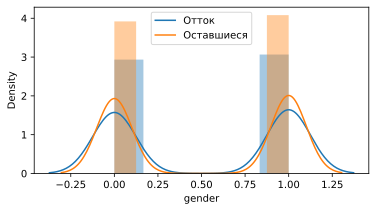

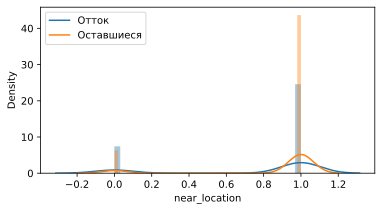

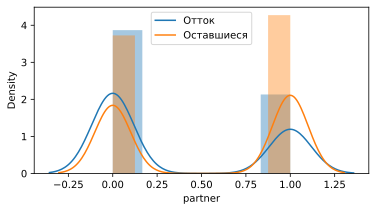

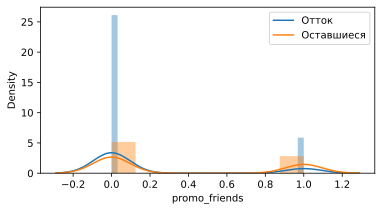

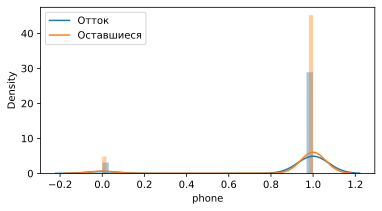

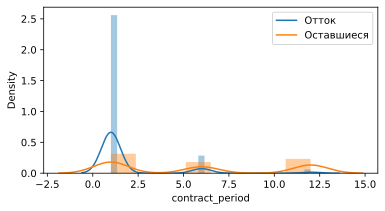

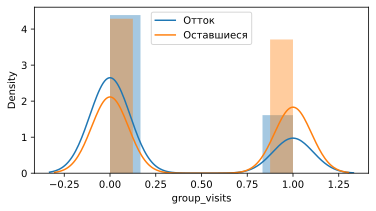

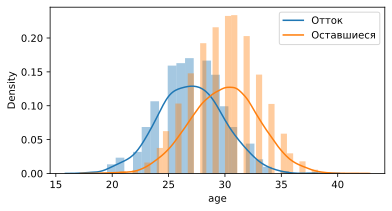

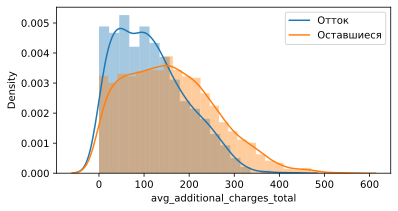

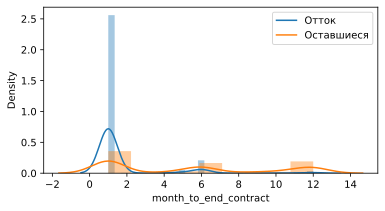

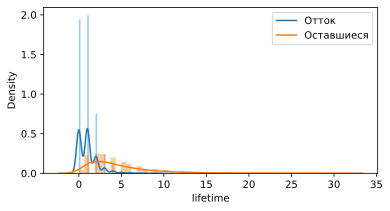

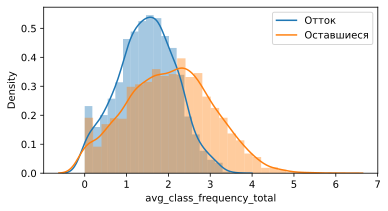

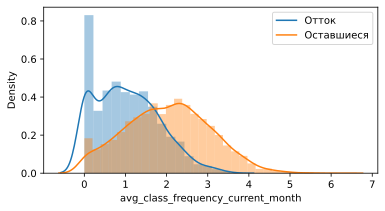

In [9]:
# построим график распределения признаков для тех, кто ушел и кто остался
left = gym[gym['churn']== 1]
stayed = gym[gym['churn']== 0]
for column in gym.drop('churn',axis=1).columns: 
  plt.figure(figsize=(6,3)) 
  plt.title(colnames.get(column))
  sns.distplot(left[column])
  sns.distplot(stayed[column])
  #plt.axvline(np.median(left[column]),color='b', linestyle='--')
  #plt.axvline(np.median(stayed[column]),color='r', linestyle='--')
  plt.legend(['Отток', 'Оставшиеся'])
  plt.show()

Посмотрим на графики: 
- по признаку "gender" распределение равномерно, по "near_location" - оставшихся существеннно больше, чем ушедших, что логично; - по признаку "partner" - оставшихся больше среди тех, кто пришел по партнерской программе; 
- по акции "приведи друга" - отток меньше среди тех кто, участвует в программе; - признак "phone" - не информативен для распределения по оттоку; 
- по признаку "contract_period" - наибольший отток среди тех, кто только начал ходить;
- по посещению групповых занятий оставшихся больше среди тех, кто посещает; 
- по возрасту в наибольший отток попали клиенты в основном до 30 лет; 
- по выручке от допольнительных услуг клуба - в отток попали те, кто редко что-то покупает в баре и тд.;
- по признаку "month_to_end_contract" - опять же в оттоке те, кто только начал посещать клуб, у кого абонемент на 6 и 12 месяцев - в основном остаются;
- по "lifetime" - в оттоке те, кто ходит около месяца или кто купил абонемент лишь на 1 месяц; 
- "средняя частота посещений в неделю" - в оттоке те клиенты, кто ходит примерно 1 раз в неделю, реже 2 раза; 
- "средняя частота посещений за месяц" - наибольший отток клиентов, редко посещающих клуб, остаются те, кто часто ходит(2 раза и больше)

In [10]:
#for i in gym.drop('churn', axis=1).columns:  
 #   fig, ax = plt.subplots(figsize=(6, 3))

  #  ax = sns.boxplot(y=gym[i], data=gym, x='churn')
   # ax.set_title(colnames.get(i))
  #  ax.set_ylabel("")
  #  ax.set_xlabel("")
    #if i == 'avg_additional_charges_total':
     #   ax.set_yticks(np.arange(0, df[i].max()+1, step=50))
    #else:
     #   ax.set_yticks(np.arange(df[i].min(), df[i].max()+1))

   # plt.show()

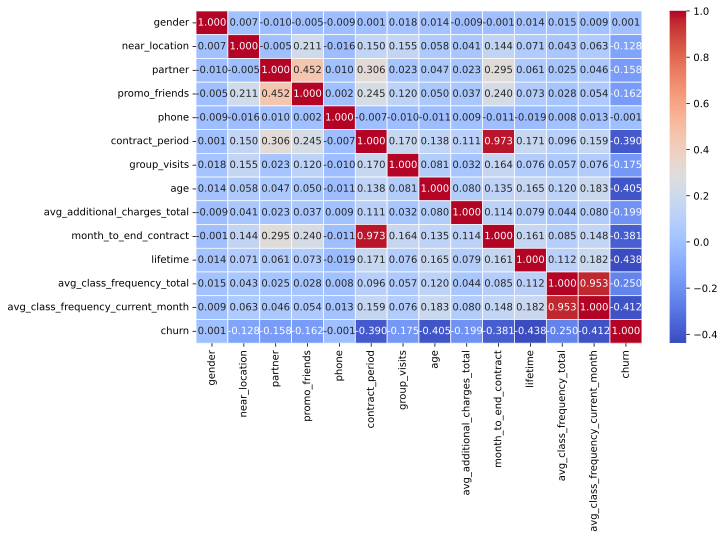

In [11]:
# построим матрицу корреляций

df_corr = gym.corr()

f, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_corr, fmt=".3f", annot=True, linewidths=.7, ax=ax, cmap = 'coolwarm')
#i, k = ax.get_ylim()
#ax.set_ylim(i+1.0, k-0.4)
#plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.show()

Посмотрим на тепловую карту корреляций признаков: 
- между собой сильно коррелируют две пары признаков - срок абонемента (contract_period) и количество месяцев до конца абонемента (month_to_end_contract)
- средняя частота посещений за весь период (avg_class_frequency_total) и средняя частота посещений за последний месяц (avg_class_frequency_current_month). Это говорит нам о том, что большинство покупает абонемент на 1 месяц, на это следует обратить внимание маркетологов. 
- С целевой переменной churn ничего сильно не коррелирует. Небольшая отрицательная корреляция есть с признаком lifetime.

#### <a href="#contents">Шаг 3: Модель прогнозирования оттока посетителей

In [12]:
# посмотрим, как соотносятся классы набора данных
print('Соотношение классов:\n', gym['churn'].value_counts())


Соотношение классов:
 0    2939
1    1061
Name: churn, dtype: int64


In [13]:
print('Количество строк до удаления выбросов:', len(gym))

for feature in col_list:
    # Вычисляем 99-й перцентиль для каждого признака:
    p99 = gym.describe(percentiles = [0.99]).T['99%'][feature] 
    gym = gym[gym[feature] <= p99]

print('Количество строк после удаления выбросов:', len(gym))

Количество строк до удаления выбросов: 4000
Количество строк после удаления выбросов: 3830


In [14]:
# перед построением модели удалим пол и возраст, не скорреливанные с целевым признаком
#gym = gym.drop(['gender','age'], axis=1).copy()

In [15]:
# Функция, выводящая метрики:
def print_all_metrics(y_true, y_pred, title):
    print('\033[1m' + colored(title, 'green'))
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred))) 

In [16]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop('churn', axis=1)
y = gym['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# зададим алгоритм для нашей модели
lr_model = LogisticRegression(solver='liblinear', random_state=0)

# обучим модель
lr_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_probabilities = lr_model.predict_proba(X_test)[:, 1]

# бинарный прогноз
lr_predictions = lr_model.predict(X_test)

In [17]:
# Обучим StandartScaler на обучающей выборке:
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных:
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# Зададим алгоритм для модели на основе алгоритма случайного леса:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# Обучим модель случайного леса:
rf_model.fit(X_train_st, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы:
rf_predictions = rf_model.predict(X_test_st)

In [18]:
# Выведем все метрики:
print_all_metrics(y_test, lr_predictions, title= 'Метрики для алгоритма логистической регрессии:')
print_all_metrics(y_test, rf_predictions, title = 'Метрики для модели случайного леса:')

Метрики для алгоритма логистической регрессии:
	Accuracy: 0.93
	Precision: 0.91
	Recall: 0.81
	F1: 0.86
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.87
	Recall: 0.84
	F1: 0.85


- Доля правильных ответов (Accuracy) для моделей логистической регрессии и случайного леса - 93% и 92% соотвественно. 
- Точность (Precision) у модели логистической регрессии существенно выше (92% против 86%).
- Полнота (Recall) у модели случайного леса чуть выше (83% против 81%).
- F1-мера также у модели логистической регрессии выше (86% против 84%)
- Таким образом, модель логистической регрессии в нашем случае показала чуть лучшие результаты.

#### <a href="#contents">Шаг 4: Кластеризация пользователей

In [19]:
# Выделим данные для кластеризации:
X = gym.drop('churn', axis = 1)

# Стандартизируем:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Строим таблицу расстояний между объектами:
linked = linkage(X_sc, method = 'ward') 

# Визуализируем (строим дендрограмму):
plt.figure(figsize=(10, 6))  
dendrogram(linked, orientation='top')
plt.show()

На дендрограмме алгоритм отрисовал 4 кластера, они не одинаковы по количеству. С помощью алгоритма K-Mean разделю клиентов на 5 кластеров - по ТО проекта.

In [20]:
km = KMeans(n_clusters = 5, random_state = 0)

# Прогнозируем кластеры для наблюдений:
labels = km.fit_predict(X_sc)

# Cохраняем метки кластера в поле нашего датасета:
gym['cluster_km'] = labels

In [21]:
# сгруппируем данные по каждому кластеру и посмотрим на его средние значения
display(gym.groupby('cluster_km').agg('mean').T)

cluster_km                              0       1       2       3       4
gender                              0.485   0.571   0.530   0.496   0.497
near_location                       1.000   0.986   0.859   0.000   0.955
partner                             0.369   0.329   0.470   0.470   0.784
promo_friends                       0.248   0.224   0.314   0.081   0.573
phone                               1.000   1.000   0.000   1.000   1.000
contract_period                     1.979   2.404   4.781   2.268  10.916
group_visits                        0.333   0.460   0.422   0.211   0.534
age                                28.063  29.917  29.270  28.435  29.966
avg_additional_charges_total      128.348 153.982 143.389 131.529 157.192
month_to_end_contract               1.885   2.234   4.481   2.122   9.976
lifetime                            2.241   4.505   3.662   2.648   4.574
avg_class_frequency_total           1.170   2.617   1.794   1.656   1.986
avg_class_frequency_current_month   0.919   2.598   1.660   1.467   1.979
churn                               0.545   0.104   0.276   0.455   0.028

Посмотрим на распределения признаков: 
- по полу распределение по всем кластерам примерно одинаковое, хотя по кластеру №3 заметно ниже - 0,486, 
- по близости к клубу тоже выделяется кластер №3 - 0,719 - то есть клиенты этого кластера работают/живут далеко от клуба по сравнению с другими кластерами, 
- клиентов по партнерской программе больше всего в кластере №4, 
- по признаку "наличие телефона" - только в кластере №0 совсем отсутствуют, 
- по длительности абонемента - самый большой показатель в кластере №2, 
- далее по групповым посещениям - кластер №3 - самый низкий показатель - 0,276, 
- средний возраст по кластерам 28-29 лет, 
- по выручке от допольнительных услуг клуба - самый высокий показатель в кластере №2, а самый низкий - в кластере №3, 
- по месяцам до конца абонемента - самый высокий показатель в кластере №2, 
- по длительности посещения - лидирует кластер № 2, 
- по признакам частоты посещений - самые высокие показатели в кластере №1, по оттоку - хуже всех показатель в кластере №3. 
- Итак, что очевидно: кластер №3 самый ненадежный.

In [22]:
#cluster_name = [0, 1, 2, 3, 4]
#for cluster in cluster_name:
#    plt.figure(figsize=(10,4))
#    plt.title(colnames.get(column))
 #   sns.distplot(gym[gym['cluster_km'] == cluster])
    #gym[gym['cluster_km']==cluster].plot.hist(figsize=(12,8))
#    plt.xlabel('')
#    plt.ylabel('')
 #   plt.legend()
 #   plt.suptitle('\nРаспределение признаков для кластера {}'.format(cluster), fontsize = 15)
  #  plt.show()

In [23]:
# напишем функцию для отрисовки графиков распределения признаков по кластерам
def draw_cluster_plot(df, feature, title):
    #fig, ax = plt.subplots(figsize=(15,6))
    
    cluster_name = gym['cluster_km'].unique()
    cluster_name = np.sort(cluster_name)
    clusters = [gym.loc[gym['cluster_km'] == i] for i in cluster_name]
    
    for cluster in clusters:
        sns.distplot(cluster[feature], label=cluster['cluster_km'].unique(), hist=True) 
        #sns.countplot(x='cluster_km', hue=feature, data=gym, ax=plt.subplot(1, 2, 1))
        plt.xlabel('')
        plt.ylabel('')
        plt.legend()
        
    #sns.boxplot(y = gym[feature], x = gym['cluster_km'], ax = plt.subplot(1, 2, 2))
    #sns.countplot(x='cluster_km', hue=feature, data=gym, ax=plt.subplot(1, 2, 2))
    #plt.xlabel('')
    #plt.ylabel('')
    plt.title(title + ' (' + feature + ') по кластерам')
    plt.show()                 

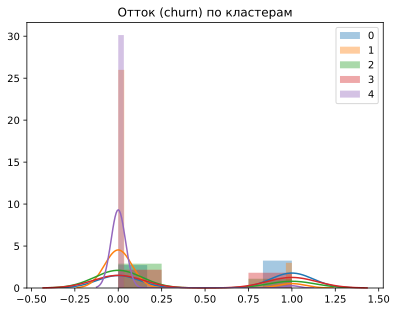

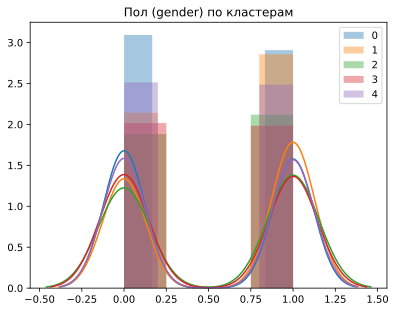

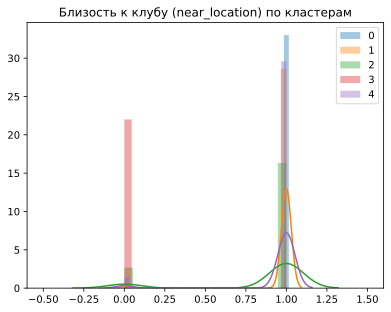

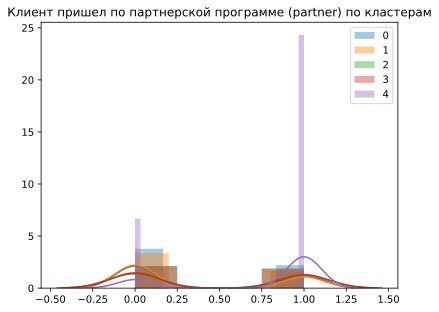

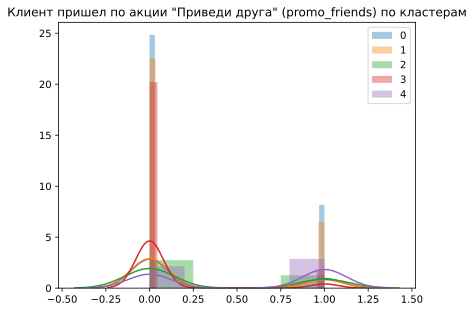

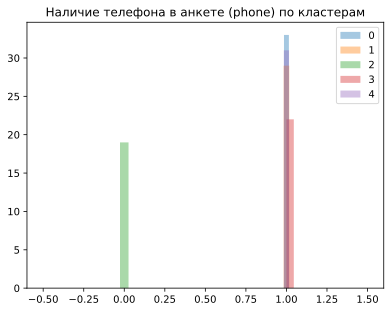

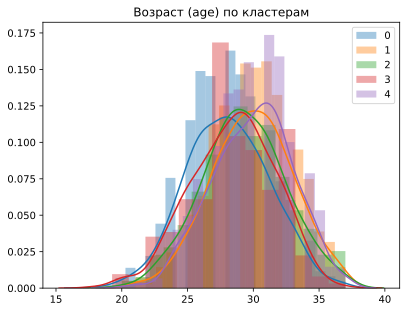

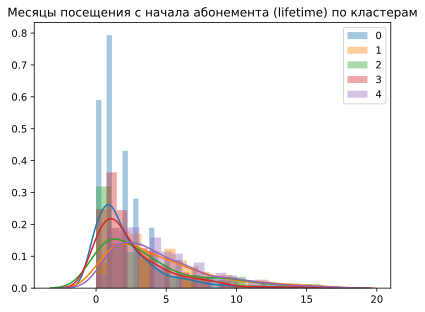

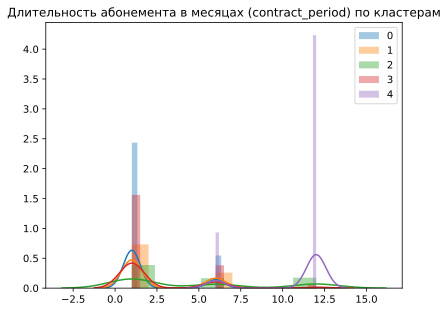

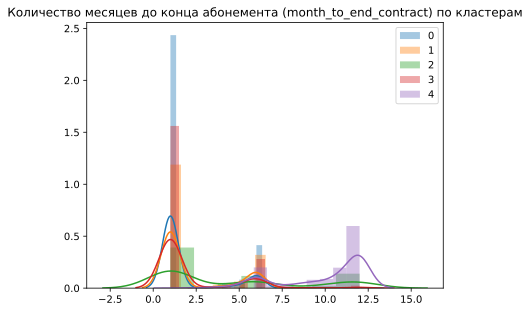

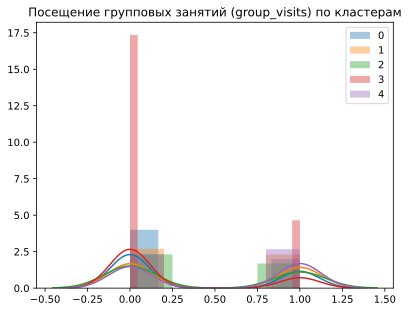

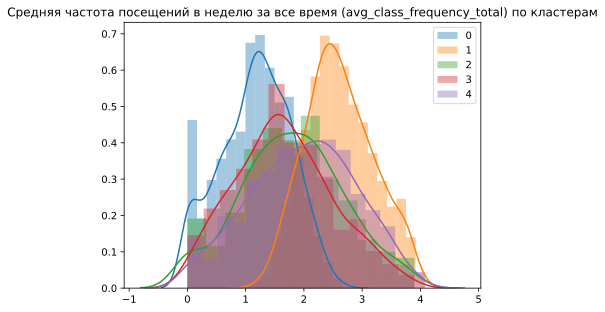

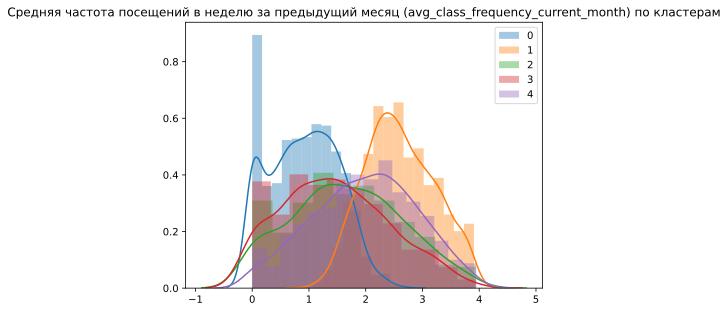

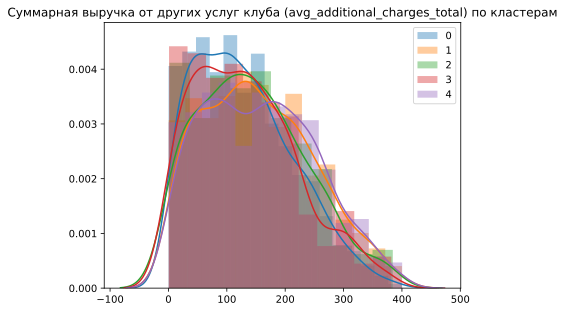

In [24]:
for index, row in colnames.iterrows():
    draw_cluster_plot(gym, row[0], row[1])    

Графики распределений признаков по кластеров подтверждают выводы, сделанные выше.

In [25]:
gym.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn', 'cluster_km'],
      dtype='object')

In [26]:
# поситаем долю оттока по кластерам
churn_ratio = gym.groupby('cluster_km').agg({'churn':['count', 'sum']}).reset_index()
churn_ratio.columns = ['cluster', 'cnt_all', 'cnt_churn']
churn_ratio['ratio_churn'] = round(churn_ratio['cnt_churn'] / churn_ratio['cnt_all'] * 100, 1)
churn_ratio.sort_values('ratio_churn', ascending=False)

cluster  cnt_all  cnt_churn  ratio_churn
0        0     1131        616       54.500
3        3      492        224       45.500
2        2      370        102       27.600
1        1      868         90       10.400
4        4      969         27        2.800

Самый высокий показатель оттока в кластере №3, самый лучший показатель - кластер №2 - самый надежный. Маркетологам, наверное, стоит оринетироваться на показатели в этом кластере.

#### <a href="#contents">Шаг 5: Основные выводы и рекомендации по проекту:

После проведения анализа и подготовки данных нам удалось разработать алгоритм для предсказывания оттока клиентов на уровне следующего месяца с полнотой 81% (доля оттока, которую удаётся обнаружить). Также можно сказать, что единого признака, влияющего на отток, не обнаружилось. На отток клиентов влияет ряд признаков.

Алгоритм кластеризации помог нам собрать следующие портреты клиентов (номера соответствуют номерам кластеров):

№0 - средний возраст клиента 29 лет, живет/работает близко к клубу, примерно половина пришли по партнерской программе, участвуют в акции "приведи друга", в этот кластер попали клиенты, не указавшие номер телефона, покупают абонемент на 3 и больше месяцев, посещают групповые занятия, пользуются дополнительными услугами клуба, занимаются больше 3 месяцев, посещают клуб примерно 2 раза в неделю, примерно треть из них уйдут в отток(показатель оттока - 0,276);

№1 - возраст клиента 29-30 лет, живет/работает близко к клубу, не участвует ни в одной акции/программе, номер телефона указан, покупают абонемент на 3 месяца, посещают групповые занятия, пользуются допольнительными услугами клуба, в среднем посещают клуб 2-3 раза в неделю, показатель оттока - низкий - всего 0,113;

№2 - возраст 29-30 лет, живет/работает близко к клубу, в этом кластере больше всего клиентов из партнеров клуба, пришли с друз ьями, телефон указан у всех клиентов в этом кластере, выбрали абонемент на 12 месяцев, посещают групповые занятия, пользуются дополнительными услугами клуба чаще других клиентов, в среднем посещают клуб 2 раза в неделю. показатель оттока - на уровне 0,023 - самый низкий по кластерам;

№3 - 27-28 лет, не работают/не живут близко от клуба - самый низкий показатель - 0,719, не участвует ни в одной акции/программе, номер телефона указан, покупают абонемент на 1-3 месяца, не посещают групповые занятия, не пользуются дополнительными услугами клуба или очень редко, посещают примерно 1 раз в 1-2 недели, больше половины из них уйдут в отток - самый высокий показатель - 0,587;

№4 - 29 лет, живет/работает близко к клубу, примерно половина пришла по партнерской программе, все клиенты этого кластера пришли по акции "Приведи друга", номер телефона указан, купили абонемент только на 3 месяца, группы посещают, естественно приносят клубу выручку от дополнительных услуг, ходят примерно 1-2 в неделю, показатель оттока - 0,255 - к сожалению в этом кластере примерно треть отвалится в отток.

Рекомендации по удержанию клиентов:

Самые ненадежные клиенты в кластерах 0, 3 и 4. Их необходимо подтянуть до показателей кластеров 1 и 2. 
Возможно, самая частая причина оттока клиентов - для тех, кто только начал посещать фитнес-клуб (у них просто нет еще привычки заниматься спортом и скорее всего просто не знают чего хотят и вообще с чего начать) - так называемое "одиночество" в клубе - их никто не ведет, нет наставника, поскольку индивидульные тренировки всегда платные, и таким клиентам кажется зачастую, что это лишняя трата денег, что они сами смогут. По моему мнению, новичкам можно предложить индивидуальные тренировки, составление плана тренировок на первых неделях абонемента, что называется "подсадить" на тренировки, поощрять первые успехи, например, бесплатными напитками в фитнес-баре и тому подобные акции. Также можно предлагать более гибкий график тем, кто далеко работает/живет от клуба. 